##**Step 1: Import Libraries and Dataset**

In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import helper

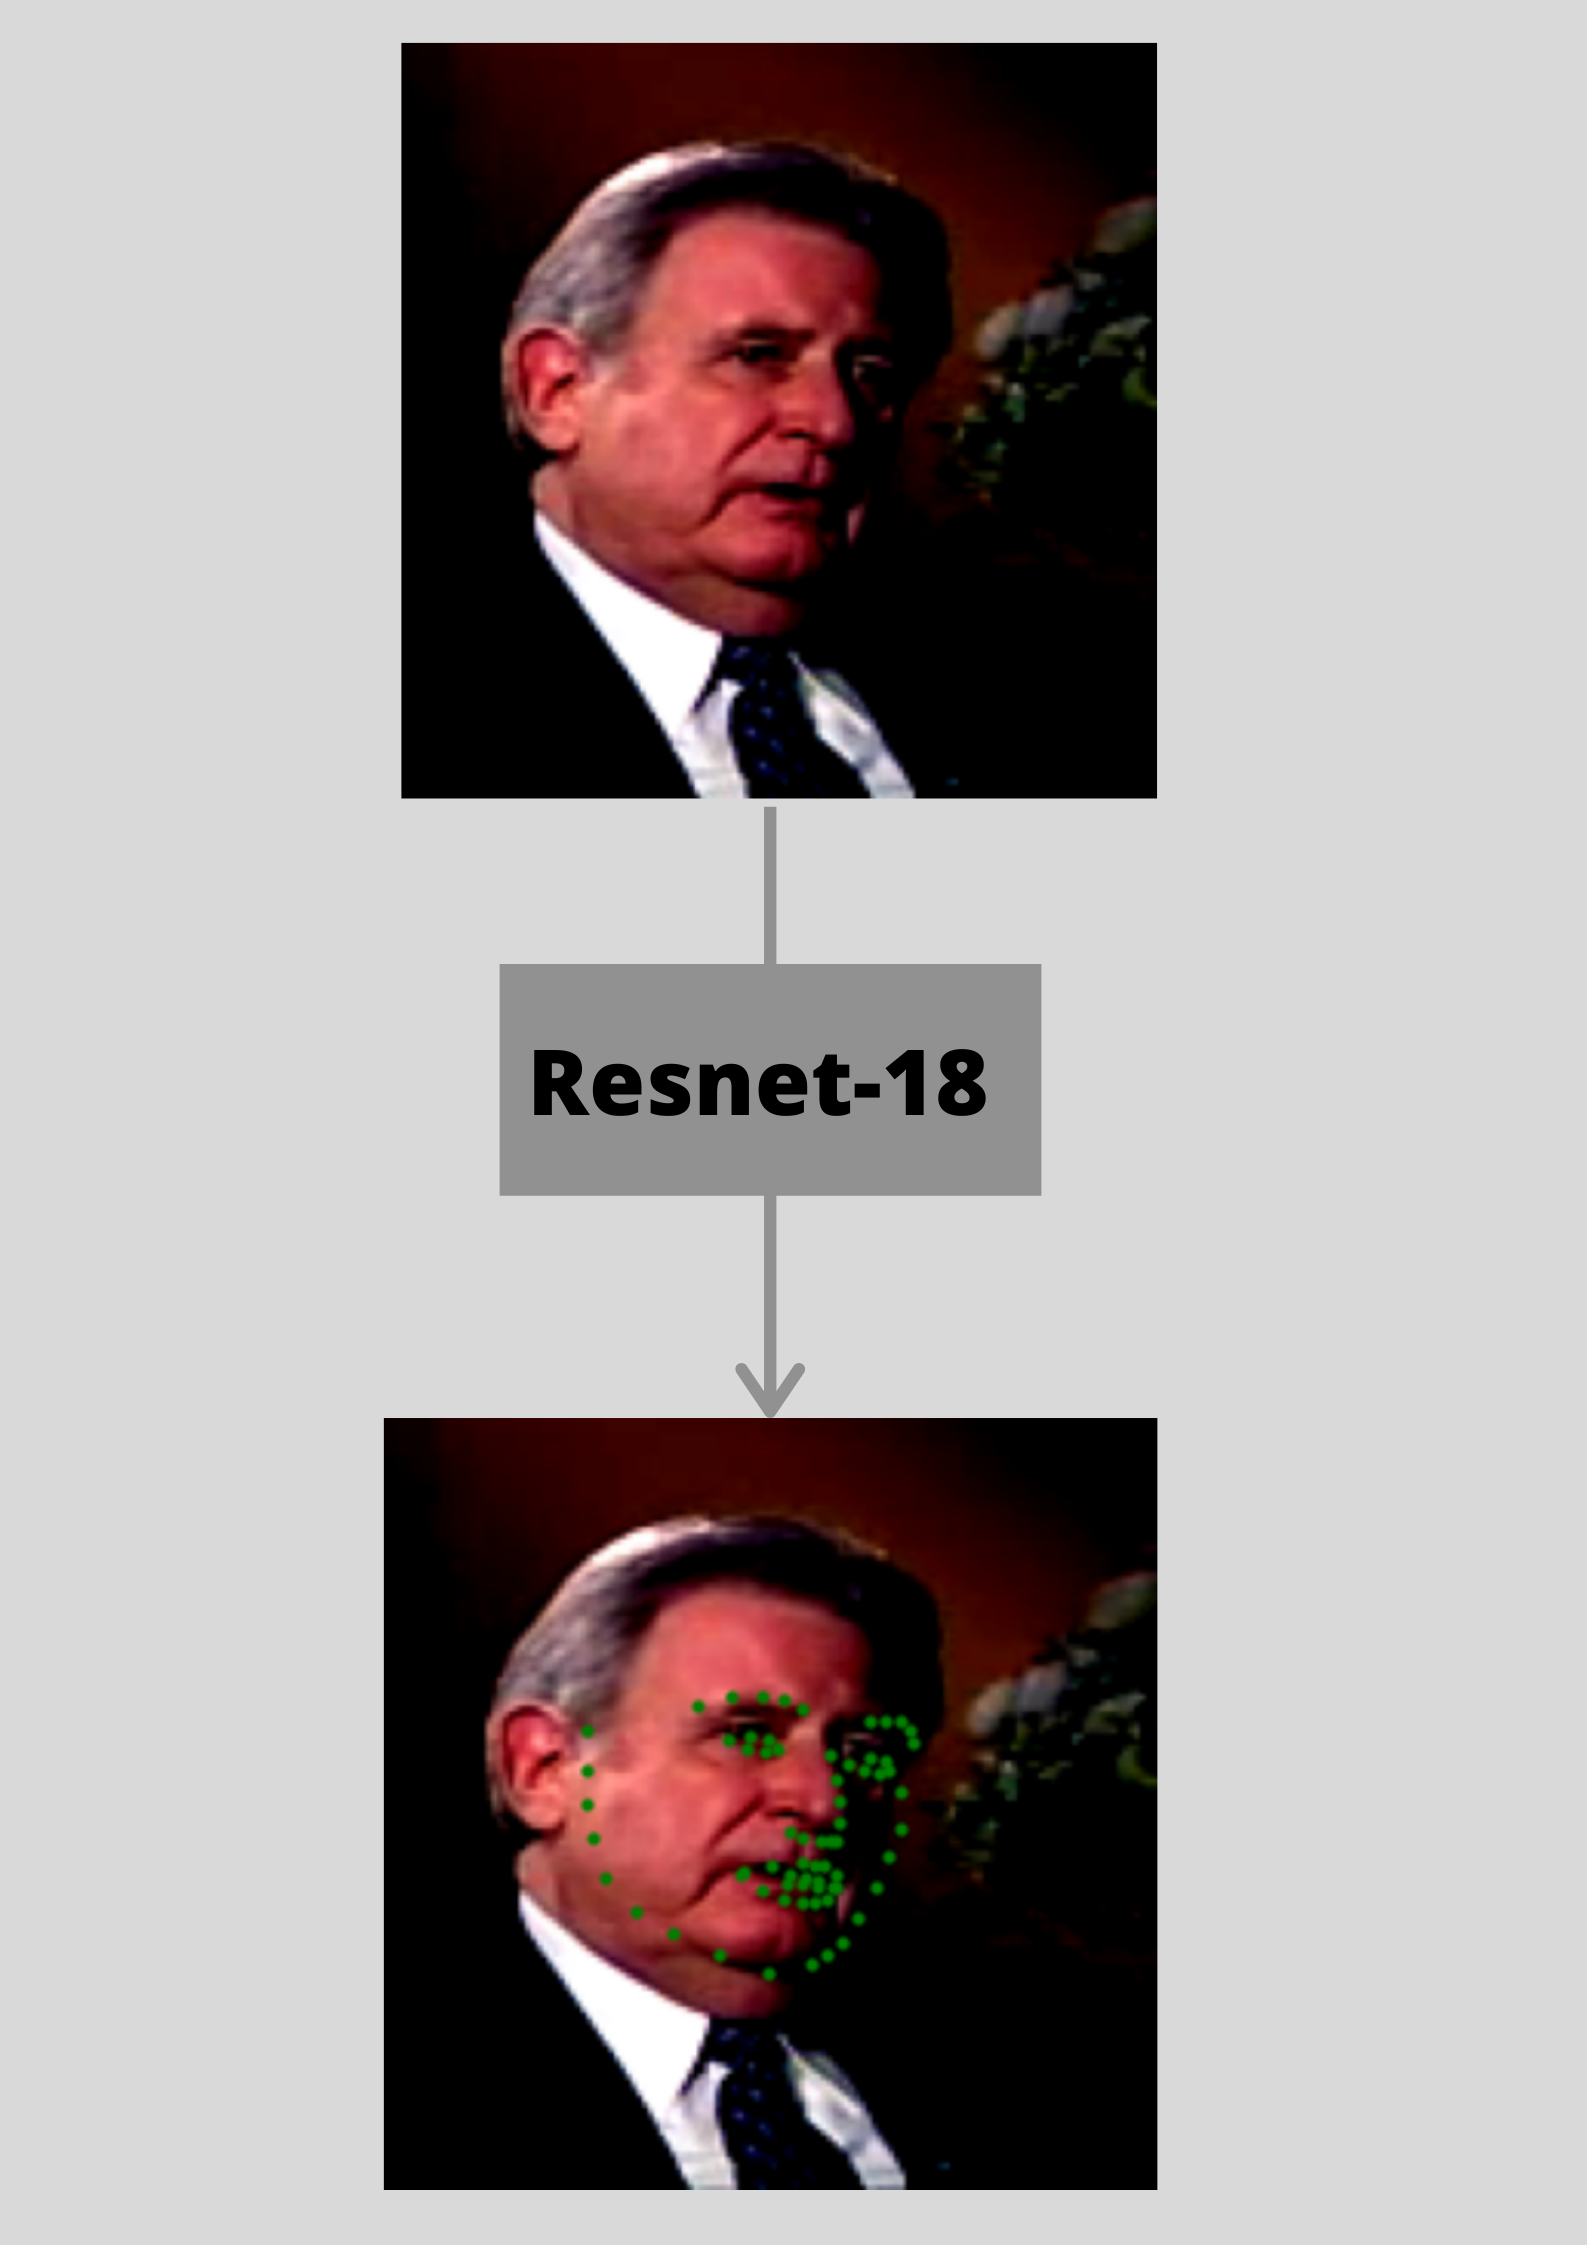

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content'
# ! kaggle datasets download -d tarunkr/facial-keypoints-68-dataset

# Download dataset
# !mkdir /data
# !wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip

In [ ]:
!unzip -n /content/training.zip -d /content

Archive:  /content/training.zip


In [ ]:
!unzip -n /content/test.zip -d /content

Archive:  /content/test.zip


#**Step 2: Setup Configs**

In [ ]:
TRAIN_IMG_DIR = '/content/training/'
TEST_IMG_DIR = '/content/test/'

TRAIN_CSV = '/content/training_frames_keypoints.csv'
TEST_CSV = '/content/test_frames_keypoints.csv'

BATCH_SIZE = 16
IMG_SIZE = 140

LEARNING_RATE = 0.001
EPOCHS = 15
MODEL_NAME = 'resnet18'

# ! pip install pycuda
DEVICE = 'cpu' 

#**Step 3: Understand Facial Keypoint Dataset** 

In [ ]:
df_train = pd.read_csv(TRAIN_CSV)
print(df_train.info())
print(df_train.head())
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3462 entries, 0 to 3461
Columns: 137 entries, Unnamed: 0 to 135
dtypes: float64(136), object(1)
memory usage: 3.6+ MB
None
                   Unnamed: 0     0     1     2  ...   132    133   134    135
0           Luis_Fonsi_21.jpg  45.0  98.0  47.0  ...  81.0  122.0  77.0  122.0
1       Lincoln_Chafee_52.jpg  41.0  83.0  43.0  ...  83.0  122.0  79.0  122.0
2       Valerie_Harper_30.jpg  56.0  69.0  56.0  ...  75.0  105.0  73.0  105.0
3         Angelo_Reyes_22.jpg  61.0  80.0  58.0  ...  91.0  139.0  85.0  136.0
4  Kristen_Breitweiser_11.jpg  58.0  94.0  58.0  ...  88.0  122.0  84.0  122.0

[5 rows x 137 columns]
                 0            1  ...          134          135
count  3462.000000  3462.000000  ...  3462.000000  3462.000000
mean     56.967938    91.170422  ...    94.860485   129.129116
std      24.778216    29.267132  ...    36.035303    41.984812
min     -17.000000    23.000000  ...    31.000000    47.000000
25%      40.00

In [ ]:
df_test = pd.read_csv(TEST_CSV)
print(df_test.info())
print(df_test.head())
print(df_test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Columns: 137 entries, Unnamed: 0 to 135
dtypes: float64(136), object(1)
memory usage: 824.3+ KB
None
                   Unnamed: 0     0     1     2  ...   132    133   134    135
0     James_Wolfensohn_00.jpg  25.0  44.0  25.0  ...  39.0   65.0  38.0   65.0
1       Valerie_Harper_30.jpg  55.0  62.0  52.0  ...  75.0  104.0  70.0  104.0
2  Kristen_Breitweiser_11.jpg  60.0  88.0  60.0  ...  94.0  117.0  89.0  117.0
3       Elizabeth_Dole_31.jpg  41.0  96.0  43.0  ...  96.0  122.0  94.0  122.0
4             Kit_Bond_20.jpg  35.0  67.0  37.0  ...  73.0   98.0  69.0   98.0

[5 rows x 137 columns]
                0           1           2  ...         133         134         135
count  770.000000  770.000000  770.000000  ...  770.000000  770.000000  770.000000
mean    56.990909   90.677922   57.741558  ...  129.089610   95.041558  128.820779
std     23.162257   29.027097   23.042042  ...   42.540592   34.621428   42.3078

[[56.0 69.0]
 [56.0 77.0]
 [56.0 86.0]
 [56.0 94.0]
 [58.0 103.0]
 [60.0 111.0]
 [62.0 116.0]
 [67.0 122.0]
 [75.0 127.0]
 [86.0 127.0]
 [96.0 123.0]
 [105.0 121.0]
 [113.0 114.0]
 [118.0 106.0]
 [122.0 100.0]
 [124.0 91.0]
 [128.0 81.0]
 [58.0 56.0]
 [62.0 54.0]
 [67.0 54.0]
 [71.0 56.0]
 [73.0 59.0]
 [90.0 65.0]
 [94.0 65.0]
 [101.0 65.0]
 [107.0 68.0]
 [111.0 72.0]
 [79.0 74.0]
 [77.0 78.0]
 [75.0 84.0]
 [75.0 88.0]
 [71.0 93.0]
 [73.0 93.0]
 [75.0 95.0]
 [79.0 95.0]
 [82.0 95.0]
 [62.0 67.0]
 [65.0 67.0]
 [69.0 67.0]
 [73.0 71.0]
 [69.0 71.0]
 [65.0 69.0]
 [92.0 76.0]
 [96.0 74.0]
 [101.0 74.0]
 [105.0 76.0]
 [99.0 78.0]
 [94.0 78.0]
 [67.0 103.0]
 [69.0 101.0]
 [73.0 101.0]
 [75.0 101.0]
 [77.0 101.0]
 [84.0 103.0]
 [88.0 108.0]
 [82.0 110.0]
 [77.0 110.0]
 [75.0 110.0]
 [71.0 110.0]
 [69.0 107.0]
 [67.0 103.0]
 [73.0 103.0]
 [75.0 105.0]
 [79.0 105.0]
 [86.0 108.0]
 [77.0 105.0]
 [75.0 105.0]
 [73.0 105.0]]


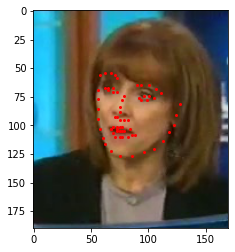

In [ ]:
# Visualize image (e.g. index 2)
index = 2
img_path = TRAIN_IMG_DIR + df_train['Unnamed: 0'].iloc[index]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

key = df_train.iloc[index][1:].to_numpy().reshape(-1, 2) #(136,) -> (68,2) 2: X and Y coordinate column
print(key)

plt.imshow(img)
plt.scatter(key[:, 0], key[:, 1], c='r', s=4)

In [ ]:
# Split dataset
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)

# Create Custom Facial Keypoint Dataset

albumentation : https://albumentations.ai/docs/  <br>

albumentation for keypoints : https://albumentations.ai/docs/examples/example_keypoints/

In [ ]:
!pip install albumentations==1.0.3
import albumentations as alb
alb.__version__

'1.0.3'

In [ ]:
class FacialKeyDataset(torch.utils.data.Dataset):

  def __init__(self, df, img_data_dir, augmentation=None):
    self.df = df
    self.img_data_dir = img_data_dir
    self.augmentation = augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    img_path = self.img_data_dir + self.df['Unnamed: 0'].iloc[index]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    key = self.df.iloc[index][1:].to_numpy().reshape(-1, 2)

    if self.augmentation != None:
      augmented_data = self.augmentation(image=img, keypoints=key)
      img = torch.from_numpy(augmented_data['image']).float()
      key = torch.tensor(augmented_data['keypoints']).float()
    
    return img.permute(2, 0, 1), key.view(-1) 
    # (H, W, C) -> (C, H, W)-- how pytorch works 
    # (68, 2) -> (136,)

In [ ]:
augmented_train = alb.Compose([
                               alb.Resize(IMG_SIZE, IMG_SIZE),
                               alb.Normalize(),
                              #  alb.HorizontalFlip(p=0.5),
                               alb.RandomBrightnessContrast(p=0.2)
], keypoint_params = alb.KeypointParams(format='xy', remove_invisible=False))

augmented_val_test = alb.Compose([
                               alb.Resize(IMG_SIZE, IMG_SIZE),
                               alb.Normalize(),
                              #  alb.HorizontalFlip(p=0.5),
                               alb.RandomBrightnessContrast(p=0.2),
], keypoint_params = alb.KeypointParams(format='xy', remove_invisible=False))

In [ ]:
training_set = FacialKeyDataset(train_df, TRAIN_IMG_DIR, augmented_train)
val_set = FacialKeyDataset(val_df, TRAIN_IMG_DIR, augmented_val_test)
test_set = FacialKeyDataset(df_test, TEST_IMG_DIR, augmented_val_test)

In [ ]:
print("Total no. of examples present in trainset : {}".format(len(training_set)))
print("Total no. of examples present in validset : {}".format(len(val_set)))

Total no. of examples present in trainset : 2769
Total no. of examples present in validset : 693


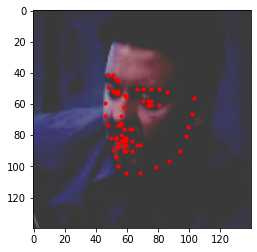

In [ ]:
# def imshow_with_key(img, key, denormalize = True):
# 	img = img.permute(1,2,0).cpu().detach().numpy()
# 	key = key.view(-1,2).cpu().detach().numpy() #(136,) -> (68,2)
	
# 	if denormalize == True:
# 		img = img * np.array([0.485, 0.456, 0.406]) + np.array([0.229, 0.224, 0.225])
		
# 	plt.imshow(img)
# 	plt.scatter(key[:,0],key[:,1], s = 10, c = 'r')
 
img, key = training_set[13]
helper.imshow_with_key(img, key)

# Load Dataset into Batches 

In [ ]:
trainloader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE)
validloader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 174
Total no. batches in validloader : 44


In [ ]:
for data in trainloader:
  image, key = data
  break

In [ ]:
print("Shape of one batch image : {}".format(image.shape))
print("Shape of one batch key : {}".format(key.shape))

Shape of one batch image : torch.Size([16, 3, 140, 140])
Shape of one batch key : torch.Size([16, 136])


# Create Model 

ckeck out timm : https://rwightman.github.io/pytorch-image-models/ (documentation), https://github.com/rwightman/pytorch-image-models (github repo)

In [ ]:
!pip install timm
import timm #pre-trained cnn models

In [ ]:
class FacialKeyModel(torch.nn.Module):
  def __init__(self, model_name = MODEL_NAME):
    super(FacialKeyModel, self).__init__()
    print('Loading Backbone: {}'.format(model_name))
    self.backbone = timm.create_model(model_name=MODEL_NAME, pretrained=True, num_classes=136)

  def forward(self, images, key=None):
    logits = self.backbone(images)

    if key != None:
      return logits, torch.nn.MSELoss()(logits, key)
    
    return logits

In [ ]:
model = FacialKeyModel()
# model.to(DEVICE)

model(torch.rand(16, 3, 140, 140)).shape

Loading Backbone: resnet18


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([16, 136])

# Trainer and Evaluator

In [ ]:
def train_function(model, trainloader, optimizer):
  train_loss = 0.0
  
  model.train()

  for data in tqdm(trainloader):

    images, keys = data
    images, keys = images.to(DEVICE), keys.to(DEVICE)

    output, loss = model(images, keys)

    optimizer.zero_grad()
    loss.backward() #dw, db
    optimizer.step() # w=w-lr*dw, b=...
    train_loss += loss.item()

  return train_loss / len(trainloader)

In [ ]:
def eval_function(model, validloader):
  val_loss = 0.0
  
  model.eval()

  with torch.no_grad():
    for data in tqdm(trainloader):

      images, keys = data
      images, keys = images.to(DEVICE), keys.to(DEVICE)

      output, loss = model(images, keys)

      val_loss += loss.item()

    return val_loss / len(validloader)

# Training model 

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_valid_loss = np.Inf

for i in range(EPOCHS):

  avg_train_loss = train_function(model, trainloader, optimizer)
  avg_val_loss = eval_function(model, validloader)

  if avg_val_loss < best_valid_loss:
    torch.save(model.state_dict(), 'FacialKeyModel.pt')
    best_valid_loss = avg_val_loss

  print('Epoch: {}; Train Loss: {}'.format(i+1, avg_train_loss))
  print('Epoch: {}; Validation Loss: {}'.format(i+1, avg_val_loss))

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 1; Train Loss: 1256.0664290176042
Epoch: 1; Validation Loss: 335.3917244130915


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 2; Train Loss: 42.171715944662864
Epoch: 2; Validation Loss: 161.96742350404912


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 3; Train Loss: 39.986719833023244
Epoch: 3; Validation Loss: 152.9584310054779


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 4; Train Loss: 28.99675778136856
Epoch: 4; Validation Loss: 108.82678508758545


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 5; Train Loss: 22.850142736544555
Epoch: 5; Validation Loss: 95.22446894645691


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 6; Train Loss: 21.45012176447901
Epoch: 6; Validation Loss: 79.60583532940258


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 7; Train Loss: 20.2174129486084
Epoch: 7; Validation Loss: 67.33636080134998


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 8; Train Loss: 17.87294222294599
Epoch: 8; Validation Loss: 68.74819287386808


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 9; Train Loss: 15.903956829816446
Epoch: 9; Validation Loss: 54.38992600007491


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 10; Train Loss: 15.12492613956846
Epoch: 10; Validation Loss: 59.66737047108737


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 11; Train Loss: 14.609659455288416
Epoch: 11; Validation Loss: 60.152452837337144


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 12; Train Loss: 13.066788248632147
Epoch: 12; Validation Loss: 41.64635819738562


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 13; Train Loss: 12.1315128666231
Epoch: 13; Validation Loss: 38.07344649054787


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 14; Train Loss: 11.22452764675535
Epoch: 14; Validation Loss: 37.12712741981853


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 15; Train Loss: 10.651763304896738
Epoch: 15; Validation Loss: 36.417022640054874


### Model Trained on Google Colab GPU : https://colab.research.google.com/drive/1tQp1IGvM7yQDZ1Weygi40mUfMPHrUd_K?usp=sharing

# Visualizing Predictions

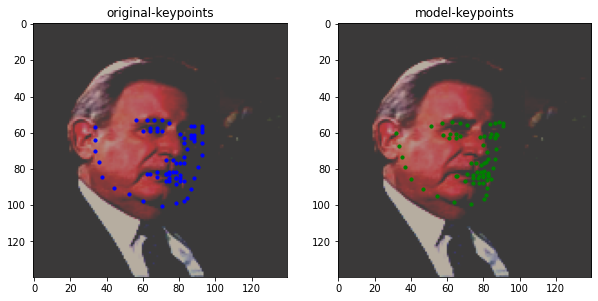

In [ ]:
index = 90
image, key = test_set[index]

model.load_state_dict(torch.load('/content/FacialKeyModel.pt', map_location = DEVICE))
model.eval()

with torch.no_grad():
  image = image.to(DEVICE)
  out_key = model(image.unsqueeze(0)) # from (c, h, w) to (bs, c, h, w)
  helper.compare_keypoints(image, key, out_key)

# Optional Task 